<a href="https://colab.research.google.com/github/DT6A/Hands-On_Machine_Learning/blob/main/ML01_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Loading data

In [ ]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = 'https://github.com/ageron/handson-ml/raw/master/'
HOUSING_PATH = os.path.join('datasets', 'housing')
HOUSING_URL = DOWNLOAD_ROOT + 'datasets/housing/housing.tgz'

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
  if not os.path.isdir(housing_path):
    os.makedirs(housing_path)
  tgz_path = os.path.join(housing_path, 'housing.tgz')
  urllib.request.urlretrieve(housing_url, tgz_path)
  housing_tgz = tarfile.open(tgz_path)
  housing_tgz.extractall(path=housing_path)
  housing_tgz.close()

In [ ]:
fetch_housing_data()

In [ ]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
  csv_path = os.path.join(housing_path, 'housing.csv')
  return pd.read_csv(csv_path)

##First glance

In [ ]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [ ]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


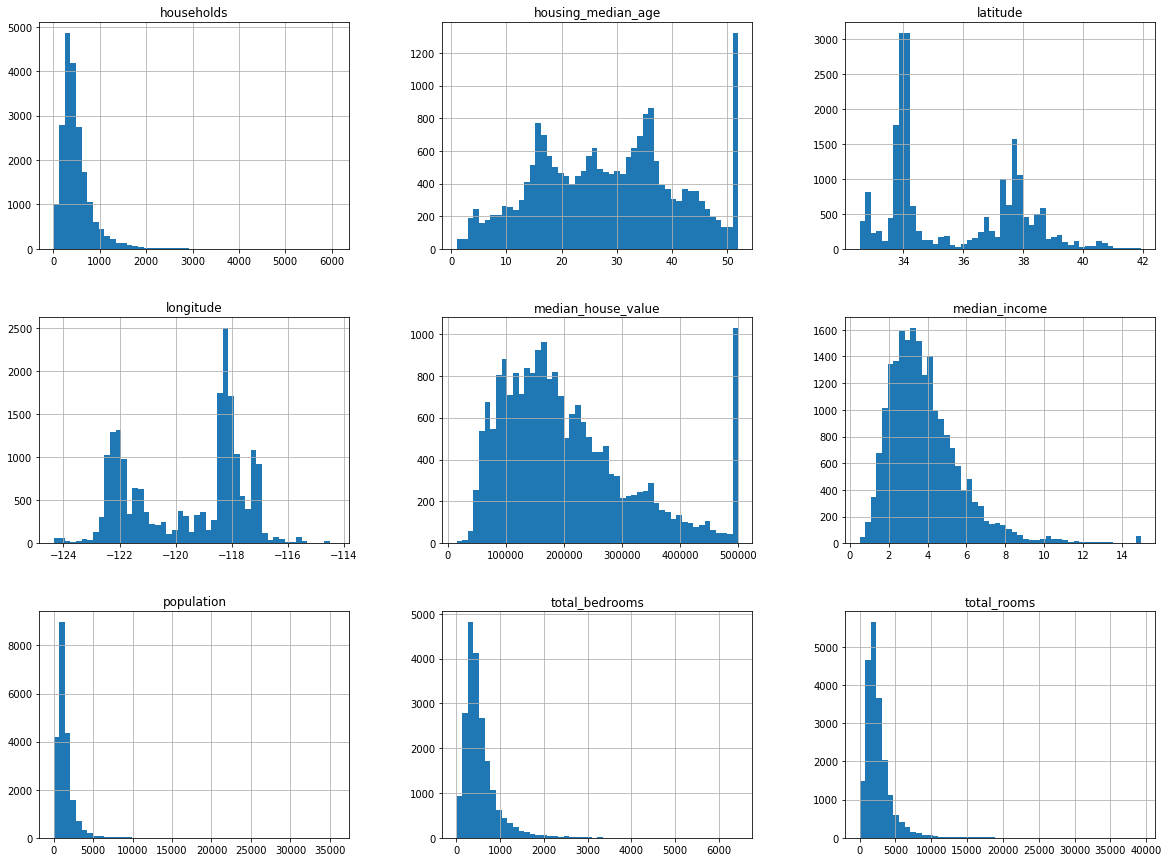

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(20, 15))
plt.show()

##Spliting data

In [ ]:
import numpy as np

def split_train_test(data, test_ratio):
  np.random.seed(42)
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data) * test_ratio)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices]

In [ ]:
train_set, test_set = split_train_test(housing, 0.2)
len(train_set), len(test_set)

(16512, 4128)

In [ ]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
  return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
  ids = data[id_column]
  in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
  return data.loc[~in_test_set], data.loc[in_test_set]

In [ ]:
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')

In [ ]:
housing_with_id['id'] = housing['longitude'] * 1000+ housing['latitude'] 
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'id')

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [ ]:
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)

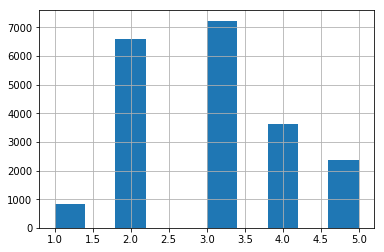

In [ ]:
housing['income_cat'].hist()

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]

In [ ]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [ ]:
strat_train_set['income_cat'].value_counts() / len(strat_train_set)

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64

In [ ]:
for set_ in (strat_train_set, strat_test_set):
  set_.drop('income_cat', axis=1, inplace=True)

##Visualizing

In [ ]:
housing = strat_train_set.copy()

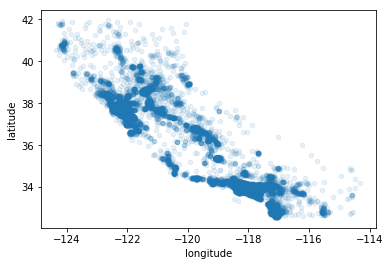

In [ ]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

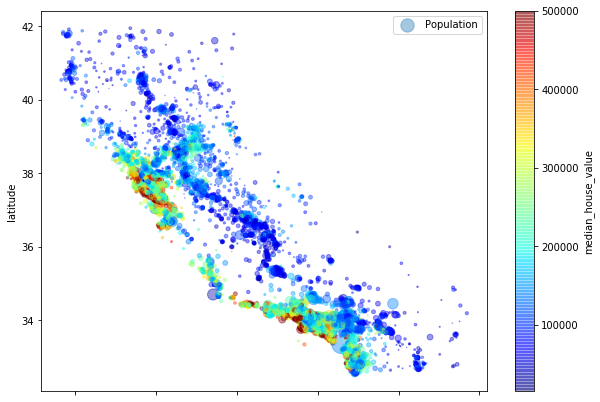

In [ ]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, 
            s=housing['population']/100, label='Population', figsize=(10,7),
            c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()

In [ ]:
corr_matrix = housing.corr()

In [ ]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f93fe70e550>,
      dtype=object)

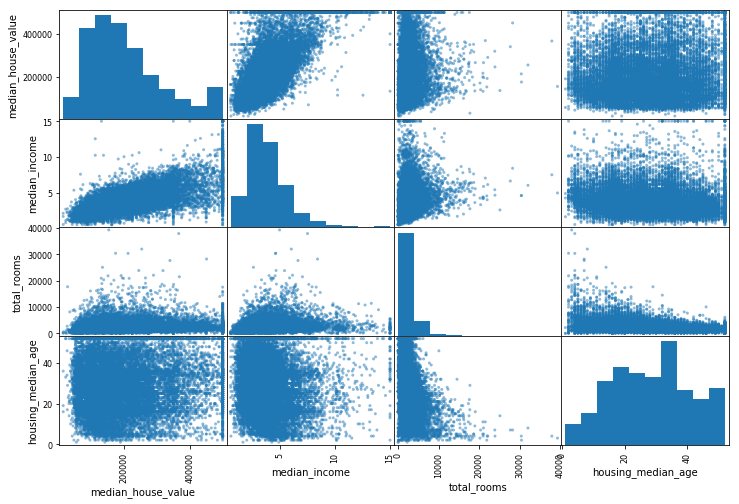

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 
              'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12, 8))

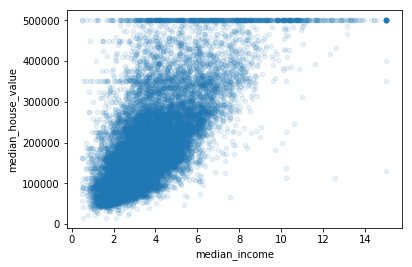

In [ ]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

##Attribute combinations

In [ ]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

In [ ]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

## Prepating data

In [ ]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

In [ ]:
housing.dropna(subset=['total_bedrooms']) # option 1
housing.drop('total_bedrooms', axis=1) # option 2
median = housing['total_bedrooms'].median() # option 3
housing['total_bedrooms'].fillna(median, inplace=True) 

In [ ]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy='median')

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [ ]:
housing_num = housing.drop('ocean_proximity', axis=1)

In [ ]:
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [ ]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [ ]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [ ]:
X = imputer.transform(housing_num)

In [ ]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [ ]:
housing_cat = housing['ocean_proximity']
housing_cat.head(10)

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
19480        INLAND
8879      <1H OCEAN
13685        INLAND
4937      <1H OCEAN
4861      <1H OCEAN
Name: ocean_proximity, dtype: object

In [ ]:
housing_cat_encoded, housing_categories = housing_cat.factorize()
housing_cat_encoded[:10]

array([0, 0, 1, 2, 0, 2, 0, 2, 0, 0])

In [ ]:
housing_categories

Index(['<1H OCEAN', 'NEAR OCEAN', 'INLAND', 'NEAR BAY', 'ISLAND'], dtype='object')

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1, 1))
housing_cat_1hot

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [ ]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [ ]:
cat_encoder = OneHotEncoder()
housing_cat_reshaped = housing_cat.values.reshape(-1, 1)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [ ]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributeAdder(BaseEstimator, TransformerMixin):
  def __init__(self, add_bedrooms_per_room=True):
    self.add_bedrooms_per_room = add_bedrooms_per_room
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if self.add_bedrooms_per_room:
      bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
      return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
    else:
      return np.c_[X, rooms_per_household, population_per_household]
    
attr_adder = CombinedAttributeAdder(False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', Imputer(strategy='median')),
    ('attribs_adder', CombinedAttributeAdder()),
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [ ]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
  def __init__(self, attribute_names):
    self.attribute_names = attribute_names
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    return X[self.attribute_names].values

In [ ]:
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy='median')),
    ('attribs_adder', CombinedAttributeAdder()),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', OneHotEncoder()),
])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [ ]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

In [ ]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

<16512x16 sparse matrix of type '<class 'numpy.float64'>'
	with 198144 stored elements in Compressed Sparse Row format>

In [ ]:
housing_prepared.shape

(16512, 16)

## Models

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [ ]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print('Predictions:', lin_reg.predict(some_data_prepared))
print('Labels:', list(some_labels))

Predictions: [210644.60465462 317768.80729055 210956.43320428  59218.98857356
 189747.55852838]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [ ]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [ ]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, 
                        scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [ ]:
def display_scores(scores):
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())  

In [ ]:
display_scores(tree_rmse_scores)

Scores: [67669.73816437 67362.61970456 70229.34328631 68299.62160307
 71291.36213287 75577.59634532 72668.53981039 70226.23940832
 77010.86953522 69438.29976359]
Mean: 70977.42297540254
Standard deviation: 3085.3445235048844


In [ ]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, 
                        scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73844317 66960.11809222 70347.95243904 74739.57055258
 68031.13389115 71193.84181183 64969.63056023 68281.61137907
 71552.91565846 67665.10081739]
Mean: 69052.46136451427
Standard deviation: 2731.674003577556


In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)

print(forest_rmse)

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, 
                        scoring='neg_mean_squared_error', cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


22389.71026586931
Scores: [51403.73351524 49668.06278086 53340.94214996 54465.69553314
 51950.77575448 54623.73297264 50620.25613238 50040.54454282
 55702.52007298 52593.228816  ]
Mean: 52440.949227049794
Standard deviation: 1960.025890239518


In [ ]:
from sklearn.externals import joblib

joblib.dump(my_model, 'my_model.pkl')
# Loading
my_model_loaded = joblib.load('my_model.pkl')

##Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [ ]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [ ]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [ ]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
  print(np.sqrt(-mean_score), params)

65305.518734865786 {'max_features': 2, 'n_estimators': 3}
55463.063788878426 {'max_features': 2, 'n_estimators': 10}
52978.951294379985 {'max_features': 2, 'n_estimators': 30}
60027.69230770106 {'max_features': 4, 'n_estimators': 3}
52909.91862865607 {'max_features': 4, 'n_estimators': 10}
50484.88983520163 {'max_features': 4, 'n_estimators': 30}
60141.391196840705 {'max_features': 6, 'n_estimators': 3}
52017.11079048709 {'max_features': 6, 'n_estimators': 10}
49889.09833435548 {'max_features': 6, 'n_estimators': 30}
59426.296278798014 {'max_features': 8, 'n_estimators': 3}
51945.047671017106 {'max_features': 8, 'n_estimators': 10}
49990.79982039442 {'max_features': 8, 'n_estimators': 30}
62472.37378205247 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54855.04501404 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60117.05136152284 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52631.49066521332 {'bootstrap': False, 'max_features': 3, 'n_estimators':

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.59589433e-02, 7.81002110e-02, 4.28503680e-02, 1.77745483e-02,
       1.60971666e-02, 1.75922993e-02, 1.62287426e-02, 3.34187004e-01,
       5.81656394e-02, 1.07103219e-01, 8.08563218e-02, 1.00778811e-02,
       1.34833145e-01, 5.93760827e-05, 3.32024461e-03, 6.79488985e-03])

In [ ]:
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_encoder = cat_pipeline.named_steps['cat_encoder']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

sorted(zip(feature_importances, attributes), reverse=True)

[(0.3341870039890608, 'median_income'),
 (0.13483314477663969, 'INLAND'),
 (0.10710321930987061, 'pop_per_hhold'),
 (0.08085632180408638, 'bedrooms_per_room'),
 (0.07810021099435599, 'latitude'),
 (0.07595894333344998, 'longitude'),
 (0.058165639357674284, 'rooms_per_hhold'),
 (0.04285036797402527, 'housing_median_age'),
 (0.01777454831607723, 'total_rooms'),
 (0.017592299257180234, 'population'),
 (0.01622874264009945, 'households'),
 (0.01609716663726076, 'total_bedrooms'),
 (0.010077881068120954, '<1H OCEAN'),
 (0.0067948898486822566, 'NEAR OCEAN'),
 (0.0033202446106837297, 'NEAR BAY'),
 (5.937608273241624e-05, 'ISLAND')]

In [ ]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [ ]:
final_rmse

47541.546386763584

In [ ]:
from sklearn.svm import SVR

sv_reg = SVR()
sv_reg.fit(housing_prepared, housing_labels)

housing_predictions = sv_reg.predict(housing_prepared)
sv_mse = mean_squared_error(housing_labels, housing_predictions)
sv_rmse = np.sqrt(sv_mse)

print(sv_rmse)

sv_scores = cross_val_score(sv_reg, housing_prepared, housing_labels, 
                        scoring='neg_mean_squared_error', cv=10)
sv_rmse_scores = np.sqrt(-sv_scores)
display_scores(sv_rmse_scores)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


118577.43356412371


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default 

Scores: [111393.33263237 119546.71049753 116961.00489445 120449.0155974
 117622.20149716 122303.76986818 117640.09907103 121459.63518806
 120348.51364519 118025.61954959]
Mean: 118574.99024409598
Standard deviation: 2934.1329433145675


In [ ]:

param_grid = [
    {'kernel': ['linear'], 'C': [0.2, 0.4, 0.6, 0.8]},
    {'kernel': ['rbf'], 'C': [0.4, 0.6, 0.8], 'gamma': [0.3, 0.5, 0.7, 1]}
]

sv_reg = SVR()

grid_search = GridSearchCV(sv_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'kernel': ['linear'], 'C': [0.2, 0.4, 0.6, 0.8]}, {'kernel': ['rbf'], 'C': [0.4, 0.6, 0.8], 'gamma': [0.3, 0.5, 0.7, 1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [ ]:
grid_search.best_params_

{'C': 0.8, 'kernel': 'linear'}

In [ ]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
  print(np.sqrt(-mean_score), params)

117592.9157867338 {'C': 0.2, 'kernel': 'linear'}
116231.5549507633 {'C': 0.4, 'kernel': 'linear'}
114966.50254666505 {'C': 0.6, 'kernel': 'linear'}
113757.4470626259 {'C': 0.8, 'kernel': 'linear'}
118856.90147913068 {'C': 0.4, 'gamma': 0.3, 'kernel': 'rbf'}
118883.94848903637 {'C': 0.4, 'gamma': 0.5, 'kernel': 'rbf'}
118896.6287743336 {'C': 0.4, 'gamma': 0.7, 'kernel': 'rbf'}
118906.50478353024 {'C': 0.4, 'gamma': 1, 'kernel': 'rbf'}
118826.3047666186 {'C': 0.6, 'gamma': 0.3, 'kernel': 'rbf'}
118866.0912384885 {'C': 0.6, 'gamma': 0.5, 'kernel': 'rbf'}
118885.53815073638 {'C': 0.6, 'gamma': 0.7, 'kernel': 'rbf'}
118899.61118653072 {'C': 0.6, 'gamma': 1, 'kernel': 'rbf'}
118795.74285946877 {'C': 0.8, 'gamma': 0.3, 'kernel': 'rbf'}
118849.92991362407 {'C': 0.8, 'gamma': 0.5, 'kernel': 'rbf'}
118874.4583497484 {'C': 0.8, 'gamma': 0.7, 'kernel': 'rbf'}
118892.64006733823 {'C': 0.8, 'gamma': 1, 'kernel': 'rbf'}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

sv_reg = SVR()

rand_search = RandomizedSearchCV(sv_reg, param_grid[0], 10, cv=5, scoring='neg_mean_squared_error')
rand_search.fit(housing_prepared, housing_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'kernel': ['linear'], 'C': [0.2, 0.4, 0.6, 0.8]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [ ]:
top_attributes_num = ['median_income', 'INLAND', 'pop_per_hhold', 'bedrooms_per_room', 'latitude', 'longitude', 'rooms_per_hhold', 
                  'housing_median_age', 'total_rooms', 'population', 'households', 'total_bedrooms', 
                  '<1H OCEAN', 'NEAR OCEAN', 'NEAR BAY', 'ISLAND']

class TopFeaturesSelector(BaseEstimator, TransformerMixin):
  def __init__(self, top_attr_num):
    self.top_attr_num = top_attr_num
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    return X[top_attributes[:self.top_attr_num]].values

In [ ]:
def indices_of_top_k(arr, k): 
  return np.sort(np.argpartition(np.array(arr), -k)[-k:]) 
class TopFeatureSelector(BaseEstimator, TransformerMixin): 
  def __init__(self, feature_importances, k): 
    self.feature_importances = feature_importances 
    self.k = k 
  def fit(self, X, y=None): 
    self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k) 
    return self 
  def transform(self, X): 
    return X[:, self.feature_indices_] 


In [ ]:
k = 5

In [ ]:
preparation_and_feature_selection_pipeline = Pipeline([ 
    ('preparation', full_pipeline), 
    ('feature_selection', TopFeatureSelector(feature_importances, k)) ])

In [ ]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

In [ ]:
prepare_select_and_predict_pipeline = Pipeline([ 
    ('preparation', full_pipeline), 
    ('feature_selection', TopFeatureSelector(feature_importances, k)), 
    ('svm_reg', SVR(**rand_search.best_params_)) 
])

In [ ]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(memory=None,
     steps=[('preparation', FeatureUnion(n_jobs=None,
       transformer_list=[('num_pipeline', Pipeline(memory=None,
     steps=[('selector', DataFrameSelector(attribute_names=['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income'])),...gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))])